In [2]:
import openmm as mm
import openmm.app as app
import openmm.unit as unit
import numpy as np
from sys import stdout
import seaborn as sns
import matplotlib.pyplot as plt


def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)


def calculate_angle(point1, point2, point3):
    vec1 = point1 - point2
    vec2 = point3 - point2
    cosine_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    angle_rad = np.arccos(cosine_angle)
    return np.degrees(angle_rad)


# Load the initial structure from a file and apply scaling factors.
ribosome_data = np.loadtxt('ribosome.txt')
ribosome_data *= 0.67  # Apply scaling factor
ribosome_data *= 0.1   # Convert units to nanometers

# Define an element to be used for atoms in the system.
element = app.Element(number=500, name='C1', symbol='C1', mass=20)


def create_system(element, positions, box_dim=500.0):
    """
    Create an OpenMM topology with atoms placed at specified positions and define bonds.

    Parameters:
        element (app.Element): The element used for each atom.
        positions (np.ndarray): A numpy array of atom positions.
        box_dim (float): Dimension of the periodic box in nanometers (default is 500.0).

    Returns:
        tuple: (topology, positions) where topology is an OpenMM Topology object,
               and positions is a numpy array with nanometer units.
    """
    topology = app.Topology()
    chain = topology.addChain()
    # Create a single residue for all atoms.
    residue = topology.addResidue("CG", chain)

    # Add atoms to the topology.
    for pos in positions:
        topology.addAtom("C1", element, residue)

    # Create bonds between every pair of atoms.
    atoms = list(topology.atoms())
    for i, atom_i in enumerate(atoms):
        for atom_j in atoms[i + 1:]:
            topology.addBond(atom_i, atom_j)

    # Round positions to three decimals and assign nanometer units.
    rounded_positions = np.around(positions, decimals=3) * unit.nanometer

    # Ensure the number of positions matches the number of atoms in the topology.
    if len(rounded_positions) != topology.getNumAtoms():
        raise ValueError("Mismatch between number of positions and atoms in topology.")

    # Define the periodic box vectors.
    box_vectors = np.array([
        [box_dim / 2.0, 0.0, 0.0],
        [0.0, box_dim / 2.0, 0.0],
        [0.0, 0.0, box_dim]
    ]) * unit.nanometer
    topology.setPeriodicBoxVectors(box_vectors)

    return topology, rounded_positions


def add_forcefield(topology, positions):
    """
    Create an OpenMM system from the topology and add a harmonic bond force
    between all bonded atoms using the distance between atoms as the equilibrium distance.

    Parameters:
        topology (app.Topology): The topology with atoms and bonds.
        positions (np.ndarray): Atom positions with unit nanometer.

    Returns:
        mm.System: The OpenMM system object with forces added.
    """
    system = mm.System()
    system.setDefaultPeriodicBoxVectors(*topology.getPeriodicBoxVectors())

    # Add particles with their respective masses.
    for atom in topology.atoms():
        system.addParticle(atom.element.mass)

    # Create a harmonic bond force.
    harmonic_bond_force = mm.HarmonicBondForce()
    for bond in topology.bonds():
        pos1 = positions[bond.atom1.index]
        pos2 = positions[bond.atom2.index]
        distance = calculate_distance(pos1, pos2)
        # Add a bond with the calculated equilibrium distance and a force constant of 100.
        harmonic_bond_force.addBond(bond.atom1.index, bond.atom2.index, distance, 100)

    system.addForce(harmonic_bond_force)
    return system

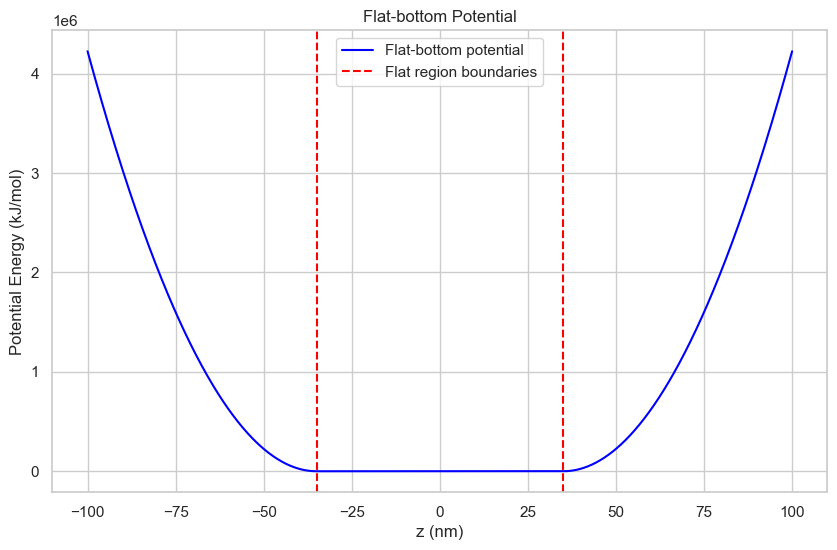

In [3]:
# Define the flat-bottom potential function
def flat_bottom_potential(z, z0, r0, k):
    distance = np.abs(z - z0)
    return np.where(distance > r0, k * (distance - r0)**2, 0)

# Parameters for the potential
z0 = 0.0  # Reference position
r0 = 35.0  # Flat-bottom radius
k = 1000.0  # Force constant

# Generate a range of z values
z_values = np.linspace(-100, 100, 1000)
potential_values = flat_bottom_potential(z_values, z0, r0, k)

# Plot the potential
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=z_values, y=potential_values, color="blue", label="Flat-bottom potential")
plt.axvline(x=z0 - r0, color="red", linestyle="--", label="Flat region boundaries")
plt.axvline(x=z0 + r0, color="red", linestyle="--")
plt.title("Flat-bottom Potential")
plt.xlabel("z (nm)")
plt.ylabel("Potential Energy (kJ/mol)")
plt.legend()
plt.show()

In [4]:
# Create the system topology and positions using ribosome_data with a box dimension of 80.0 nm.
topology, positions = create_system(element, positions=ribosome_data, box_dim=80.0)
system = add_forcefield(topology, positions)

# Define a custom flat-bottom potential along the z-axis with periodic boundary conditions.
# The potential expression applies a harmonic restraint only when the distance in z exceeds a threshold.
force_expression = (
    "step(periodicdistance(0, 0, z, 0, 0, z0) - r0) * k * "
    "(periodicdistance(0, 0, z, 0, 0, z0) - r0)^2"
)
flat_bottom_force = mm.CustomExternalForce(force_expression)
flat_bottom_force.addPerParticleParameter("r0")
flat_bottom_force.addPerParticleParameter("k")
flat_bottom_force.addPerParticleParameter("z0")

# Calculate the average z-coordinate of all positions.
average_z = np.mean(positions, axis=0)[2]

# Add the flat-bottom potential to each particle.
for particle_index in range(len(positions)):
    flat_bottom_force.addParticle(
        particle_index,
        [
            35.0 * unit.nanometer,
            1000.0 * unit.kilojoule / (unit.nanometer**2 * unit.mole),
            average_z
        ]
    )

# Add the custom force to the system.
system.addForce(flat_bottom_force)

# Set up the Langevin integrator with a high temperature, friction coefficient, and time step.
integrator = mm.LangevinIntegrator(
    1000 * unit.kelvin,    # Temperature
    1 / unit.picosecond,   # Friction coefficient
    0.010 * unit.picoseconds  # Time step
)

# Initialize the simulation with the created topology, system, and integrator.
simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(positions)

# Minimize the energy of the system.
simulation.minimizeEnergy()

# Retrieve the final positions after energy minimization.
final_positions = simulation.context.getState(getPositions=True).getPositions()

# Configure reporters to output trajectory and state data.
simulation.reporters.append(
    app.DCDReporter('traj.dcd', 5000, enforcePeriodicBox=True)
)
simulation.reporters.append(
    app.StateDataReporter(
        stdout, 5000, step=True,
        potentialEnergy=True, temperature=True,
        volume=True, speed=True
    )
)
simulation.reporters.append(
    app.CheckpointReporter('checkpoint.chk', 300000)
)

# Run the simulation for 500,000 steps.
simulation.step(500000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Speed (ns/day)"
5000,2030.8801612854004,1055.1444450868112,128000.0,0
10000,1929.3883457183838,995.8226475315174,128000.0,9.9e+03
15000,2022.0440216064453,1003.8256896550988,128000.0,1.04e+04
20000,2110.7064723968506,1030.3196141978121,128000.0,1.06e+04
25000,2064.7609119415283,1044.8756913433779,128000.0,1.08e+04
30000,1965.7773418426514,1038.6729725776256,128000.0,1.08e+04
35000,1965.6482734680176,1029.9070171935166,128000.0,1.09e+04
40000,1944.4142112731934,949.0976270718454,128000.0,1.09e+04
45000,2071.835647583008,954.717058994908,128000.0,1.09e+04
50000,2041.625831604004,996.2908650316722,128000.0,1.09e+04
55000,2263.094457626343,899.2624473138746,128000.0,1.1e+04
60000,2041.705041885376,953.124830406088,128000.0,1.1e+04
65000,2191.7889919281006,995.1661603875184,128000.0,1.1e+04
70000,2029.1043605804443,955.1124097911531,128000.0,1.1e+04
75000,2213.5991249084473,902.1966999490573,128000.0,1.1e+04
80000,1